In [1]:
import numpy as np

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
font = {'weight' : 'medium',
       'size'   : 13}
matplotlib.rc('font', **font)


import time

import concurrent.futures as cf

import warnings
warnings.filterwarnings("ignore")

import scipy.constants
mec2 = scipy.constants.value('electron mass energy equivalent in MeV')*1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value('classical electron radius')

### Parameters

In [2]:
gamma = 5000
rho = 1.5 # Bend radius in m

beta = (1-1/gamma**2)**(1/2)

sigma_x = 50e-6
sigma_z  = 50e-6

# Entrance angle
phi = 0.1/rho

## code

In [10]:
from csr2d.core2 import psi_s, psi_x0_hat
import numpy as np

In [13]:
gamma = 5000
rho = 1.5 # Bend radius in m

beta = (1-1/gamma**2)**(1/2)

sigma_x = 50e-6
sigma_z  = 50e-6
nz = 100
nx = 100

dz = (10*sigma_z) / (nz - 1)
dx = (10*sigma_x) / (nx - 1)

zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
zm, xm = np.meshgrid(zvec, xvec, indexing='ij')
psi_s_grid = psi_s(zm, xm, beta)

In [14]:
psi_x_grid = psi_x0_hat(zm, xm, beta, dx)

In [3]:
from csr2d.core2 import psi_s, psi_x_hat, psi_x0_hat
from scipy.interpolate import RectBivariateSpline
from numba import njit, vectorize, float64
from csr2d.kick2 import green_meshes_hat, green_meshes

In [5]:
# Bypassing the beam, use smooth Gaussian distribution for testing

def lamb_2d(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2)
def lamb_2d_prime(z,x):
    return 1/(2*np.pi*sigma_x*sigma_z)* np.exp(-z**2 / 2 / sigma_z**2 - x**2 / 2 / sigma_x**2) * (-z / sigma_z**2)

In [6]:
nz = 100
nx = 100

zvec = np.linspace(-5*sigma_z, 5*sigma_z, nz)
xvec = np.linspace(-5*sigma_x, 5*sigma_x, nx)
zm, xm = np.meshgrid(zvec, xvec, indexing='ij')

lambda_grid_filtered = lamb_2d(zm,xm)
lambda_grid_filtered_prime = lamb_2d_prime(zm,xm)

dz = (10*sigma_z) / (nz - 1)
dx = (10*sigma_x) / (nx - 1)

In [7]:
psi_s_grid = psi_s(zm, xm, beta)

In [8]:

psi_s_grid, psi_x_grid, zvec2, xvec2 = green_meshes_hat(nz, nx, dz, dx, rho=rho, beta=beta)  


# Integral term code development

In [9]:
# Convolution for a specific observatino point only
@njit
def my_2d_convolve2(g1, g2, ix1, ix2):
    d1, d2 = g1.shape
    g2_flip = np.flip(g2)
    g2_cut = g2_flip[d1-ix1:2*d1-ix1, d2-ix2:2*d2-ix2]
    
    sums = 0
    for i in range(d1):
        for j in range(d2):
            sums+= g1[i,j]*g2_cut[i,j]
    return sums

In [ ]:
#@njit
# njit doesn't like the condition grid and interpolation....

def transient_calc_lambda(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid):

    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    #print('x_observe_index :', x_observe_index )
    z_observe_index = np.argmin(np.abs(zvec - z_observe))
    #print('z_observe_index :', z_observe_index )

    # Boundary condition 
    temp = (x_observe - xvec)/rho
    zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
    zo_vec = -beta*np.abs(x_observe - xvec)

    condition_grid = np.array([(zvec > z_observe - zo_vec[i]) | (zvec < z_observe - zi_vec[i]) for i in range(len(xvec))])

    lambda_grid_filtered_prime_bounded = np.where(condition_grid.T, 0, lambda_grid_filtered_prime)
    
    conv_s = my_2d_convolve2(lambda_grid_filtered_prime_bounded, psi_s_grid, z_observe_index, x_observe_index) 
    conv_x = my_2d_convolve2(lambda_grid_filtered_prime_bounded, psi_x_grid, z_observe_index, x_observe_index)  
        ##conv_s, conv_x = fftconvolve2(lambda_grid_filtered_prime_bounded, psi_s_grid, psi_x_grid)
    
        #Ws_grid = (beta**2 / abs(rho)) * (conv_s) * (dz * dx)
        #Wx_grid = (beta**2 / abs(rho)) * (conv_x) * (dz * dx)

    #lambda_interp = RectBivariateSpline(zvec, xvec, lambda_grid_filtered)  # lambda lives in the observation grid
    #lambda_zi_vec = lambda_interp.ev( z_observe - zi_vec, xvec )   
    #psi_x_zi_vec = psi_x0(zi_vec/2/rho, temp, beta, dx)
    #Wx_zi = (beta**2 / rho) * np.dot(psi_x_zi_vec, lambda_zi_vec)*dx

    #lambda_zo_vec = lambda_interp.ev( z_observe - zo_vec, xvec )   
    #psi_x_zo_vec = psi_x0(zo_vec/2/rho, temp, beta, dx)
    #Wx_zo = (beta**2 / rho) * np.dot(psi_x_zo_vec, lambda_zo_vec)*dx
    
    #return Wx_grid[ z_observe_index ][ x_observe_index ], Wx_zi, Wx_zo
    #return conv_x, Wx_zi, Wx_zo
    return conv_x
    #return condition_grid

In [9]:
@njit
def transient_calc_lambda_2(phi, z_observe, x_observe, zvec, xvec, dz, dx, lambda_grid_filtered_prime, psi_s_grid, psi_x_grid):

    x_observe_index = np.argmin(np.abs(xvec - x_observe))
    #print('x_observe_index :', x_observe_index )
    z_observe_index = np.argmin(np.abs(zvec - z_observe))
    #print('z_observe_index :', z_observe_index )

    # Boundary condition 
    temp = (x_observe - xvec)/rho
    zi_vec = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))
    zo_vec = -beta*np.abs(x_observe - xvec)
    
    nz = len(zvec)
    nx = len(xvec)
    
    # Allocate array for histogrammed data
    cond = np.zeros( (nz,nx) )
    
    for i in range(nx):
        cond[:,i]  = (zvec > z_observe - zo_vec[i]) | (zvec < z_observe - zi_vec[i])
    
    #condition_grid = np.array([(zvec < z_observe - zi_vec[i]) for i in range(len(xvec))])
    #condition_grid = np.array([(zvec > z_observe - zo_vec[i]) | (zvec < z_observe - zi_vec[i]) for i in range(len(xvec))])

    lambda_grid_filtered_prime_bounded = np.where(cond, 0, lambda_grid_filtered_prime)
    
    conv_s = my_2d_convolve2(lambda_grid_filtered_prime_bounded, psi_s_grid, z_observe_index, x_observe_index) 
    conv_x = my_2d_convolve2(lambda_grid_filtered_prime_bounded, psi_x_grid, z_observe_index, x_observe_index)  
    
    
    return conv_x

# Applying the codes

### Note that numba-jitted code are slower the FIRST time

In [11]:
t1 = time.time()
r1 = transient_calc_lambda(phi, 2*sigma_z, sigma_x, zvec, xvec, dz, dx,lambda_grid_filtered_prime, psi_s_grid, psi_x_grid) 
print(r1)
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

-816013178.6486729
Mapping takes: 0.0027959346771240234 sec


In [ ]:
t1 = time.time()
r1 = transient_calc_lambda_2(phi, 2*sigma_z, sigma_x, zvec, xvec, dz, dx,lambda_grid_filtered_prime, psi_s_grid, psi_x_grid) 
print(r1)
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

## super version for parallelism

In [ ]:
def transient_calc_lambda_super(z_observe, x_observe):
    return transient_calc_lambda(phi, z_observe, x_observe, zvec, xvec, dz, dx,lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)

In [ ]:
#@njit
@vectorize([float64(float64,float64)], target='parallel')
def transient_calc_lambda_2_super(z_observe, x_observe):
    return transient_calc_lambda_2(phi, z_observe, x_observe, zvec, xvec, dz, dx,lambda_grid_filtered_prime, psi_s_grid, psi_x_grid)

In [ ]:
t1 = time.time()
with cf.ProcessPoolExecutor(max_workers=20) as executor:
    result = executor.map(transient_calc_lambda_super, zm.flatten(), xm.flatten())
    g1 = np.array(list(result)).reshape(zm.shape)
    
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

In [ ]:
t1 = time.time()
g4 = transient_calc_lambda_boundary_super_new(zm,xm)
t2 = time.time()
print('Mapping takes:', t2-t1, 'sec')

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(zm*1e5, xm*1e5, yaya , cmap='inferno', zorder=1)

ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

In [8]:
# To be fixed
from scipy.integrate import quad

def transient_calc_lambda_boundary_quad(phi, z_observe, x_observe, dx):
       
    def integrand_zi(xp):

        temp = (x_observe - xp)/rho
        zi = rho*( phi - beta*np.sqrt(temp**2 + 4*(1 + temp)*np.sin(phi/2)**2))

        #return psi_x_hat(zi/2/rho, temp, beta)*lamb_2d(z_observe - zi, xp)
        return psi_x0_hat(zi/2/rho, temp, beta, dx)*lamb_2d(z_observe - zi, xp)
    
    def integrand_zo(xp):

        zo = -beta*np.abs(x_observe - xp)
  
        #return psi_x_hat(zo/2/rho, temp, beta)*lamb_2d(z_observe - zo, xp)
        return psi_x0_hat(zo/2/rho, temp, beta, dx)*lamb_2d(z_observe - zo, xp)    
    
    return quad(integrand_zi, -5*sigma_x, 5*sigma_x)[0]/dx
    
    

In [138]:
factor = (beta**2 / rho)*dx

In [145]:
diff = np.abs((g4.reshape(zm.shape) - g3.reshape(zm.shape))/g3.reshape(zm.shape) )* 100

In [149]:
diff = np.abs((g0 - g3.reshape(zm.shape))/g3.reshape(zm.shape)) * 100

In [187]:
g3.shape

(400, 400)

Text(0.5, 0.92, '$W_x$ benchmarking')

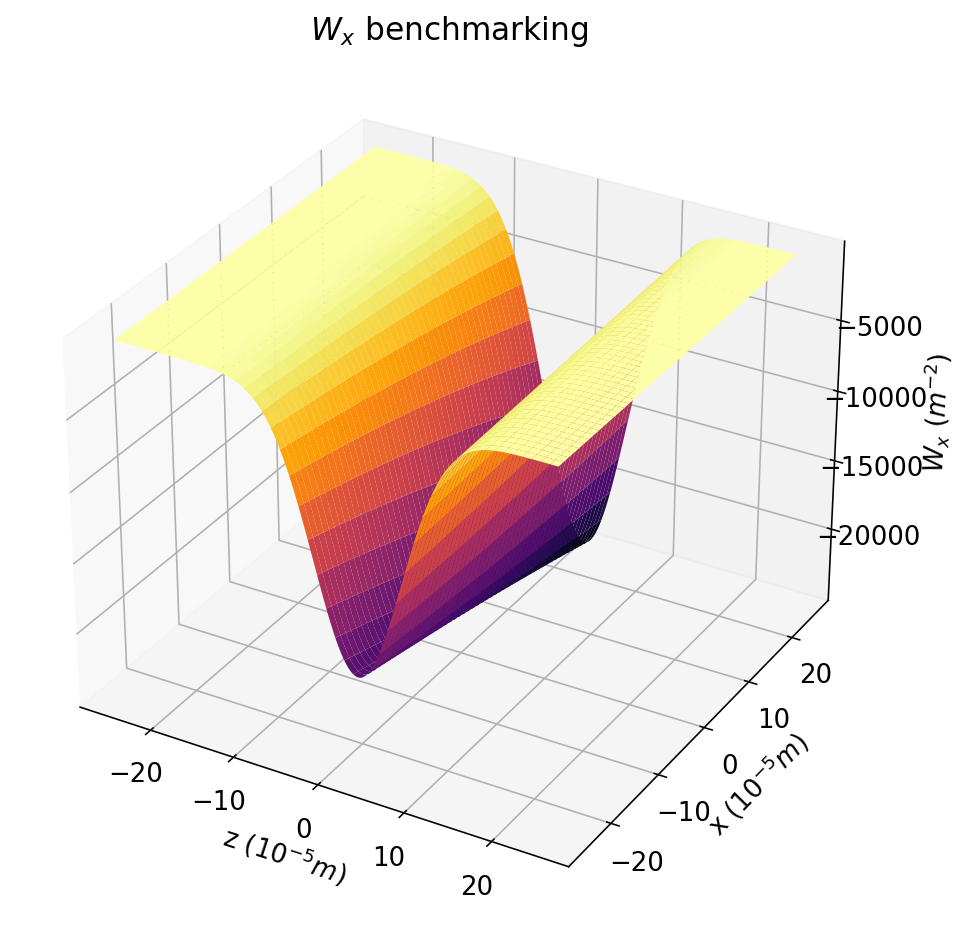

In [189]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(zm*1e5, xm*1e5, factor*g3, cmap='inferno', zorder=1)

ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(m^{-2}$) ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

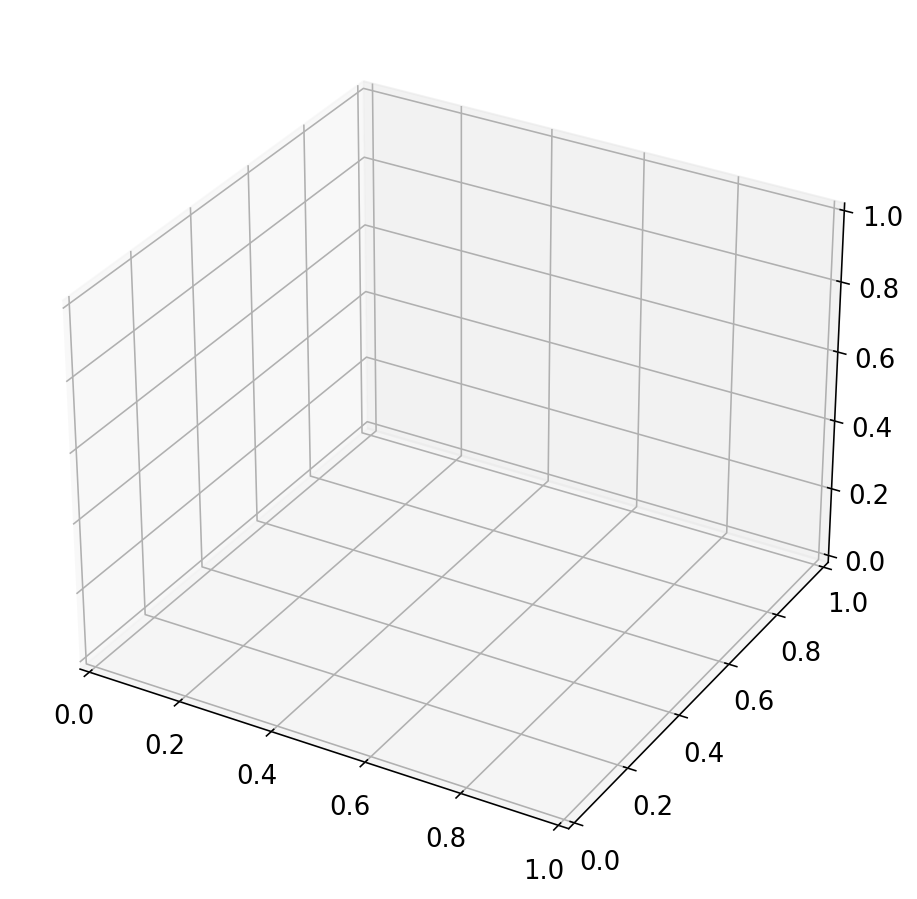

In [190]:
fig, ax = plt.subplots(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(zm*1e5, xm*1e5, diff, cmap='inferno', zorder=1)

ax.set_xlabel(r'z $(10^{-5}m)$')
ax.set_ylabel(r'x $(10^{-5}m)$')
ax.set_zlabel(r'$W_x$ $(\times 10^3/m^2)$ ')
ax.zaxis.labelpad = 10
ax.set_title(r'$W_x$ benchmarking')

In [ ]:
ax.zaxis.set_scale('log')

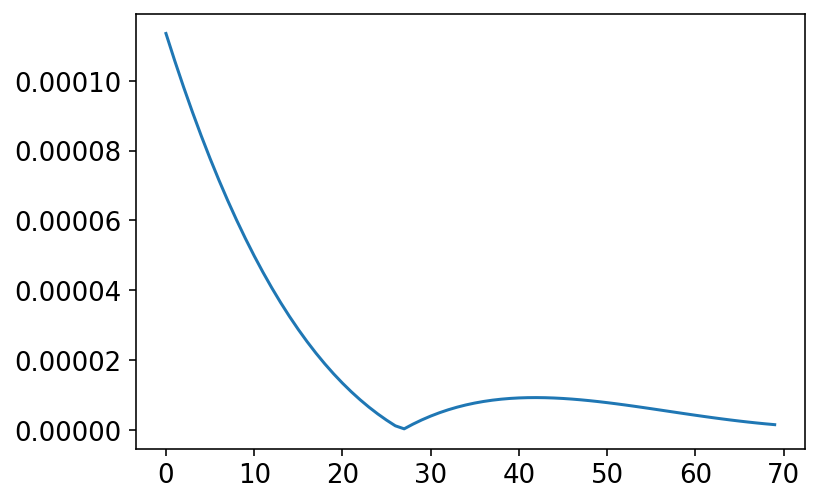

In [156]:
plt.plot(diff[30:100,100])